This example uses a scipy.sparse matrix to store the features and demonstrates various classifiers that can efficiently handle sparse matrices.

In [ ]:
# parsing command line arguments 
'''from optparse import OptionParser
def main():
    
    op = OptionParser()

    #adding new option
    op.add_option("--report",action="store_true",dest="print_report",
             help="Print a detailed classification report.")

    op.add_option("--chi2_select",action="store",type="int",dest="select_chi2",
             help="Select some number of features using a chi-squared test")

    op.add_option("--confusion_matrix",action="store_true", dest="print_cm",
              help="Print the confusion matrix.")

    op.add_option("--top10",action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")

    op.add_option("--all_categories",action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")

    op.add_option("--use_hashing",action="store_true",
              help="Use a hashing vectorizer.")

    op.add_option("--n_features",action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")

    op.add_option("--filtered",action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")

    (opts,args) = op.parse_args()
    print(opts)
    print(args)
    '''


In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]
remove = ('headers', 'footers', 'quotes')
print("Loading 20 newsgroups dataset for categories:")
print(categories)
print('data loaded')
train = fetch_20newsgroups(subset='train',categories=categories,
                          shuffle=True,random_state=42,remove=remove)
test = fetch_20newsgroups(subset='test',categories=categories,
                          shuffle=True,random_state=42,remove=remove)

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded


In [2]:
train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [3]:
print(train['target_names'])
print()
print(train['target'][:10])
print()
print(train['data'][0])

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

[1 3 2 0 2 0 2 1 2 1]

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


In [4]:
def size_mb(docs):
    print("1st document text length is : {}".format(len(docs[0].encode('utf-8'))) )
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(train.data)
data_test_size_mb = size_mb(test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(test.data), data_test_size_mb))
print("%d categories" % len(categories))
print()

1st document text length is : 608
1st document text length is : 38
2034 documents - 2.428MB (training set)
1353 documents - 1.800MB (test set)
4 categories



In [5]:
# split a training set and a test set
Y_train , Y_test = train.target , test.target
target_names = train.target_names

If n_samples == 10000, storing X as a numpy array of type float32 would require 10000 x 100000 x 4 bytes = 4GB in RAM
Fortunately, most values in X will be zeros since for a given document less than a couple thousands of distinct words will be used. 
For this reason we say that bags of words are typically high-dimensional sparse datasets. 
We can save a lot of memory by only storing the non-zero parts of the feature vectors in memory.

# Extracting features from the training data using a sparse vectorizer

From occurrences to frequencies
divide the number of occurrences of each word in a document by the total number of words in the document: 
these new features are called tf for Term Frequencies.

to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.
This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.
Both tf and tf–idf can be computed as follows:

In [6]:
print("Extracting features from the training data using a sparse vectorizer") 
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
t0= time()

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_train = vectorizer.fit_transform(train.data)  # the fit(..) method to fit our estimator to the data and 
                                                #secondly the transform(..) method to transform our count-matrix to a tf-idf representation.
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

Extracting features from the training data using a sparse vectorizer
done in 0.461553s at 5.260MB/s
n_samples: 2034, n_features: 26576



In [7]:
print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

Extracting features from the test data using the same vectorizer
done in 0.283921s at 6.339MB/s
n_samples: 1353, n_features: 26576



In [8]:
#training models
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


In [9]:
def model(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    
    t0 = time()
    clf.fit(X_train,Y_train)
    train_time = time() - t0
    
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    
    print("test time:  %0.3fs" % test_time)
    
    score = metrics.accuracy_score(Y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    print("classification report:")
    print(metrics.classification_report(Y_test, pred,
                                            target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(Y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [10]:
results=[]

for clf,name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(model(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)


C:\Users\Madhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.228s
test time:  0.002s
accuracy:   0.777
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.61      0.65       319
     comp.graphics       0.89      0.92      0.90       389
         sci.space       0.77      0.90      0.83       394
talk.religion.misc       0.70      0.59      0.64       251

       avg / total       0.77      0.78      0.77      1353

confusion matrix:
[[195  11  55  58]
 [  7 356  24   2]
 [ 18  20 353   3]
 [ 61  15  28 147]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.108s
test time:  0.002s
accuracy:   0.749
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.61      0.68

In [11]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(model(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(model(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(model(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(model(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(model(MultinomialNB(alpha=.01)))
results.append(model(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(model(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.001, verbose=0)
train time: 0.112s
test time:  0.002s
accuracy:   0.780
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.69      0.62      0.66       319
     comp.graphics       0.89      0.91      0.90       389
         sci.space       0.78      0.90      0.84       394
talk.religion.misc       0.68      0.60      0.64       251

       avg / total       0.77      0.78      0.78      1353

confusion matrix:
[[198  11  48  62]
 [  7 353  25   4]
 [ 17  20 353   4]
 [ 63  13  24 151]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilo

C:\Users\Madhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.119s
test time:  0.002s
accuracy:   0.776
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.70      0.61      0.65       319
     comp.graphics       0.89      0.90      0.89       389
         sci.space       0.78      0.89      0.83       394
talk.religion.misc       0.67      0.62      0.64       251

       avg / total       0.77      0.78      0.77      1353

confusion matrix:
[[195  13  48  63]
 [  7 350  25   7]
 [ 18  20 349   7]
 [ 59  12  24 156]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)
train time: 0.173s
test time:  0.002s
accuracy:   0.746
classification report:
                    precision    recall  f1-score   support

       alt.atheism  

C:\Users\Madhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.322s
test time:  0.002s
accuracy:   0.748
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.68      0.59      0.63       319
     comp.graphics       0.88      0.88      0.88       389
         sci.space       0.82      0.79      0.80       394
talk.religion.misc       0.55      0.68      0.61       251

       avg / total       0.75      0.75      0.75      1353

confusion matrix:
[[187  11  32  89]
 [  9 344  23  13]
 [ 23  24 311  36]
 [ 56  11  14 170]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.419s
test time:  0.001s
accurac

C:\Users\Madhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Madhu\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
print(results)

[('RidgeClassifier', 0.77679231337767918, 0.22768950462341309, 0.002040386199951172), ('Perceptron', 0.74944567627494452, 0.10830068588256836, 0.0015037059783935547), ('PassiveAggressiveClassifier', 0.7782705099778271, 0.12133002281188965, 0.0010027885437011719), ('KNeighborsClassifier', 0.25277161862527714, 0.0020062923431396484, 0.1339261531829834), ('RandomForestClassifier', 0.72209903917220986, 5.1566407680511475, 0.11578011512756348), ('LinearSVC', 0.7797487065779749, 0.11209297180175781, 0.0015039443969726562), ('SGDClassifier', 0.77605321507760527, 0.11933016777038574, 0.002004861831665039), ('LinearSVC', 0.745750184774575, 0.17347025871276855, 0.0015344619750976562), ('SGDClassifier', 0.74796747967479671, 0.32190632820129395, 0.0020062923431396484), ('SGDClassifier', 0.77014042867701404, 0.4191577434539795, 0.0010030269622802734), ('NearestCentroid', 0.75609756097560976, 0.014037132263183594, 0.002506732940673828), ('MultinomialNB', 0.78787878787878785, 0.005028247833251953, 0.

In [13]:
#plotting
import numpy as np
indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]
print(results)
clf_names, score, training_time, test_time = results


[['RidgeClassifier', 'Perceptron', 'PassiveAggressiveClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'LinearSVC', 'SGDClassifier', 'LinearSVC', 'SGDClassifier', 'SGDClassifier', 'NearestCentroid', 'MultinomialNB', 'BernoulliNB', 'Pipeline'], [0.77679231337767918, 0.74944567627494452, 0.7782705099778271, 0.25277161862527714, 0.72209903917220986, 0.7797487065779749, 0.77605321507760527, 0.745750184774575, 0.74796747967479671, 0.77014042867701404, 0.75609756097560976, 0.78787878787878785, 0.72209903917220986, 0.74501108647450109], [0.22768950462341309, 0.10830068588256836, 0.12133002281188965, 0.0020062923431396484, 5.1566407680511475, 0.11209297180175781, 0.11933016777038574, 0.17347025871276855, 0.32190632820129395, 0.4191577434539795, 0.014037132263183594, 0.005028247833251953, 0.006516695022583008, 0.1764674186706543], [0.002040386199951172, 0.0015037059783935547, 0.0010027885437011719, 0.1339261531829834, 0.11578011512756348, 0.0015039443969726562, 0.002004861831665039

In [14]:
clf_names

['RidgeClassifier',
 'Perceptron',
 'PassiveAggressiveClassifier',
 'KNeighborsClassifier',
 'RandomForestClassifier',
 'LinearSVC',
 'SGDClassifier',
 'LinearSVC',
 'SGDClassifier',
 'SGDClassifier',
 'NearestCentroid',
 'MultinomialNB',
 'BernoulliNB',
 'Pipeline']

In [15]:
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

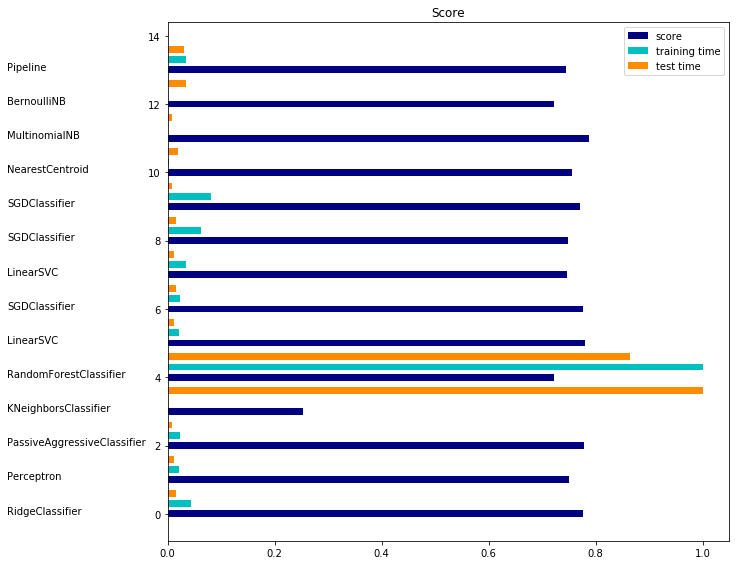

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
#plt.xticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
plt.show()